In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

 ### Model Definition

In [5]:
X, y = load_svmlight_file('diabetes.txt')
X = X.toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

imputer = SimpleImputer(missing_values=-9999, strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_size = X_train.shape[1]
hidden_size = 64
output_size = 1

model = MLPModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(torch.tensor(X_train, dtype=torch.float32))
    loss = criterion(outputs, torch.tensor(y_train, dtype=torch.float32).view(-1, 1))
    loss.backward()
    optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(torch.tensor(X_test, dtype=torch.float32))
    predicted_labels = (test_outputs > 0.5).float()


accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels, average='macro', zero_division=0)
recall = recall_score(y_test, predicted_labels, average='macro', zero_division=0)
f1 = f1_score(y_test, predicted_labels, average='macro')

fpr, tpr, _ = roc_curve(y_test, test_outputs)
roc_auc = auc(fpr, tpr)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')


Accuracy: 0.23376623376623376
Precision: 0.3076923076923077
Recall: 0.12121212121212122
F1 Score: 0.1739130434782609
ROC AUC: 0.7994490358126722


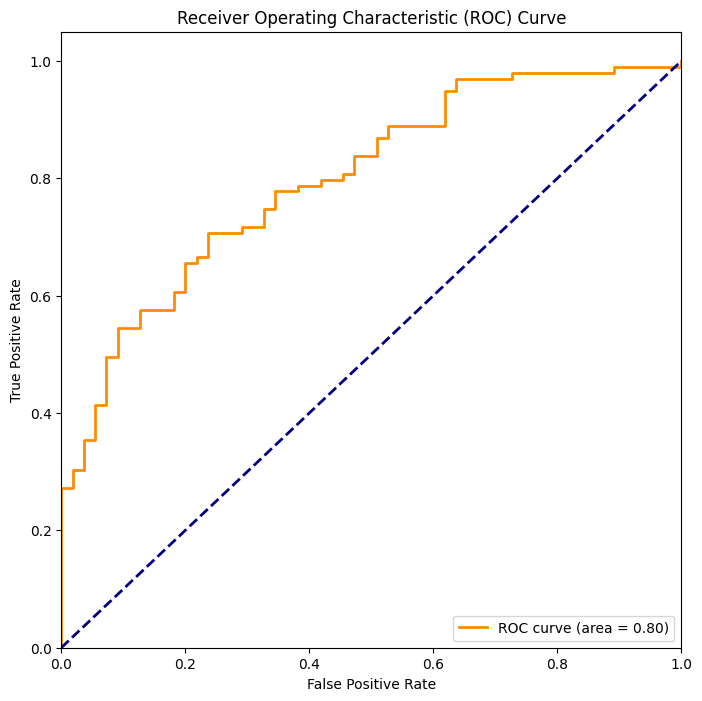

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, test_outputs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### Hyperparameter Optimization

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

model = MLPClassifier(random_state=42)

param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64, 32), (64,)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [3000, 5000, 8000],
    'early_stopping': [True, False]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

c:\Users\64985\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\64985\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\64985\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\64985\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the 

Best Hyperparameters: {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (128, 64, 32), 'max_iter': 3000}


In [10]:
best_model = grid_search.best_estimator_
predicted_labels = best_model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels, average='macro', zero_division=0)
recall = recall_score(y_test, predicted_labels, average='macro', zero_division=0)
f1 = f1_score(y_test, predicted_labels, average='macro')
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.7597402597402597
Precision: 0.7385204081632653
Recall: 0.7404040404040404
F1 Score: 0.739424703891709
ROC AUC: 0.8170798898071625


### ROC Curve

<Figure size 800x600 with 0 Axes>

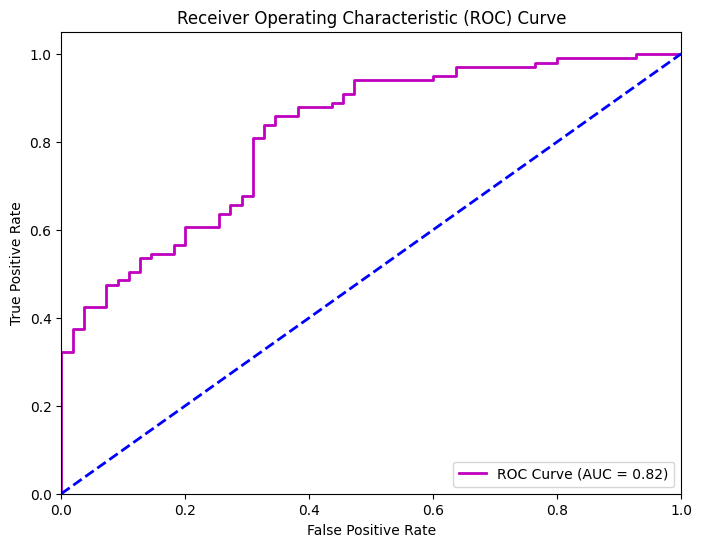

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.style.use('default')
plt.figure(figsize=(8, 6))

fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='m', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='b', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.savefig('roc_curve.png')

plt.show()


### Accuracy of Models in Different Hyperparameters

In [29]:
results = pd.DataFrame(grid_search.cv_results_)

filtered_results = results[(results['param_max_iter'] == 3000) & (results['param_early_stopping'] == True)]

# Display relevant columns for inspection
columns_to_display = ['param_hidden_layer_sizes', 'param_activation', 'param_alpha', 'mean_test_score']
table_data = filtered_results[columns_to_display]

print(table_data)


    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
75       0.095316      0.010052         0.001593        0.001157   
57       0.101339      0.014000         0.000970        0.000794   
93       0.095598      0.006069         0.002701        0.005402   
6        0.060458      0.012672         0.000437        0.000536   
24       0.064776      0.017147         0.000701        0.001401   
42       0.059856      0.020308         0.000000        0.000000   
0        0.058371      0.014502         0.000282        0.000563   
18       0.062973      0.013151         0.000201        0.000401   
36       0.058934      0.011224         0.000000        0.000000   
21       0.080586      0.005007         0.000000        0.000000   
3        0.083629      0.005904         0.001271        0.000772   
39       0.073828      0.011097         0.000000        0.000000   
90       0.042424      0.006814         0.000102        0.000205   
54       0.043817      0.003080         0.000774

In [30]:
# Sort table_data by mean_test_score
table_data_sorted = table_data.sort_values(by='mean_test_score', ascending=False)

# Print the sorted table_data
print(table_data_sorted)


   param_hidden_layer_sizes param_activation param_alpha  mean_test_score
75            (128, 64, 32)             tanh       0.001         0.765494
57            (128, 64, 32)             tanh      0.0001         0.765494
93            (128, 64, 32)             tanh        0.01         0.765494
6                     (64,)             relu      0.0001         0.763854
24                    (64,)             relu       0.001         0.763854
42                    (64,)             relu        0.01         0.763854
0                  (64, 32)             relu      0.0001         0.754085
18                 (64, 32)             relu       0.001         0.754085
36                 (64, 32)             relu        0.01         0.754085
21            (128, 64, 32)             relu       0.001         0.750793
3             (128, 64, 32)             relu      0.0001         0.750793
39            (128, 64, 32)             relu        0.01         0.749167
90                 (64, 32)           

### Scatter Plot of Accuracy of Models in Different Hyperpa-rameters

c:\Users\64985\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\64985\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\64985\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\64985\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

<Figure size 1200x500 with 0 Axes>

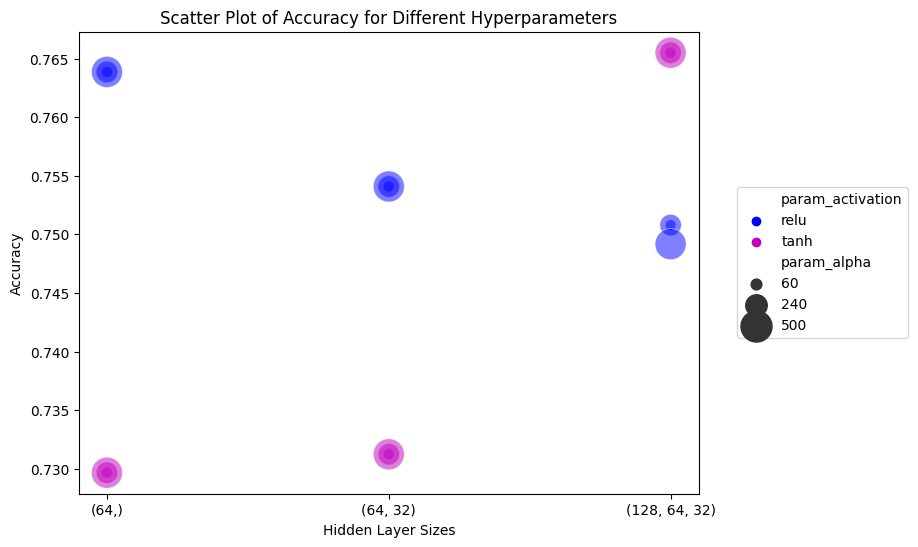

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the tuples in 'param_hidden_layer_sizes' to strings
filtered_results['param_hidden_layer_sizes'] = filtered_results['param_hidden_layer_sizes'].astype(str)

# Define the order of x-axis
order_x = ['(64,)', '(64, 32)', '(128, 64, 32)']

# Use custom colors
colors = ['blue', 'm']

plt.figure(figsize=(12, 5))

# Adjust the size based on param_alpha
size_adjustment = filtered_results['param_alpha'].map({0.0001: 60, 0.001: 240, 0.01: 500})

# Sort DataFrame by 'param_hidden_layer_sizes' order
filtered_results['param_hidden_layer_sizes'] = pd.Categorical(filtered_results['param_hidden_layer_sizes'], categories=order_x, ordered=True)
filtered_results = filtered_results.sort_values('param_hidden_layer_sizes')

# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='param_hidden_layer_sizes',
    y='mean_test_score',
    hue='param_activation',
    size=size_adjustment,
    sizes=(60, 500),
    data=filtered_results,
    palette=dict(zip(filtered_results['param_activation'].unique(), colors)),
    markers=['o', 's', 'D'],  # Define different markers for different activations
    alpha=0.5
)

# Set labels and title
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Accuracy')
plt.title('Scatter Plot of Accuracy for Different Hyperparameters')
plt.legend(title='', bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.savefig('scatter_plot.png', bbox_inches='tight')
# Show the plot
plt.show()
